# Hebrew Study Notebook

In [1]:
import os, json
from pprint import pprint
import collections
from datetime import datetime
from IPython.display import display
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from iMahir import Study

In [2]:
home_dir = os.path.expanduser('~/')
hebrew = os.path.join(home_dir, 'Documents/vocabulary/hebrew.json')

In [3]:
heb = Study(hebrew)

preparing TF...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used


hebrew ready for study.
this is session 9:
score 4: 6 terms
score 3: 236 terms
score 2: 21 terms
score 1: 21 terms
score 0: 100 terms
total: 384


In [ ]:
heb.learn()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Notes


## Study Stats

### Size of Known Term Set (Scores 3-4)

In [5]:
sessions = [sd for sd in heb.set_data['stats'] if 'score_counts' in sd]
learned_lengths = [s['score_counts']['3']+s['score_counts']['4'] for s in sessions]
unlearned_lengths = [s['score_counts']['0'] for s in sessions]
dates = [datetime.strptime(sd['date'], '%Y-%m-%d %H:%M:%S.%f') for sd in sessions]
date_labels = [datetime.strftime(time, format='%d-%m_%H:%M') for time in dates]
date2nlearned = dict(zip(date_labels, learned_lengths)) # get dict for references
date2nunlearned = dict(zip(date_labels, unlearned_lengths))

# plot this data only with cutoff
cutoff = -30 # max amount
plt_sessions = sessions[cutoff:]
plt_learned = learned_lengths[cutoff:]
plt_unlearned = unlearned_lengths[cutoff:]
plt_dates = date_labels[cutoff:]

# calculate cycle lines
cycle_bounds = []
last_cycle = None
for i, sd in enumerate(plt_sessions):
    cycle = sd['cycle']
    last_cycle = cycle if not last_cycle else last_cycle
    if last_cycle != cycle:
        cycle_bounds.append(i-0.5)
        last_cycle = cycle

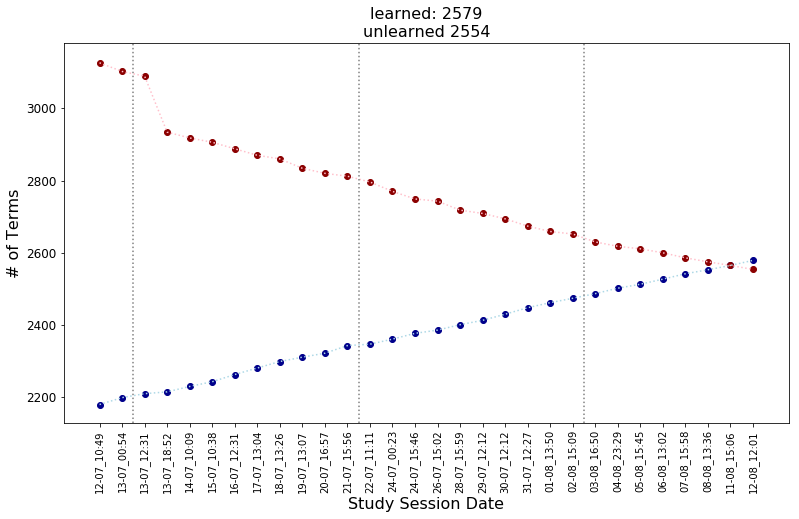

In [6]:
# make the plot
x = np.arange(len(plt_learned))
plt.figure(figsize=(13, 7))
plt.plot(x, plt_learned, linestyle='dotted', color='lightblue')
plt.scatter(x, plt_learned, color='darkblue')
plt.plot(x, plt_unlearned, linestyle='dotted', color='pink')
plt.scatter(x, plt_unlearned, color='darkred')
plt.xticks(x, plt_dates, rotation=90, size=10)
plt.yticks(size=12)
plt.ylabel('# of Terms', size=16)
plt.xlabel('Study Session Date', size=16)
plt.title(f'learned: {plt_learned[-1]}\nunlearned {plt_unlearned[-1]}', size=16)
for bound in cycle_bounds:
    plt.axvline(bound, color='grey', linestyle='dotted')
plt.show()

In [7]:
print('n-learned since last cycle:', plt_learned[-1] - date2nlearned['02-08_15:09'])

n-learned since last cycle: 105


### Update Backup

In [12]:
! cp /Users/cody/Documents/vocabulary/hebrew.json sample_vocab/.

In [13]:
! git add sample_vocab/.; git commit -m "Latest updates"

[master a58bcbc] Latest updates
 1 file changed, 1636 insertions(+), 1570 deletions(-)


In [15]:
! git add study_HB.ipynb; git commit -m "Latest session"

[master b21db57] Latest session
 1 file changed, 831 insertions(+), 795 deletions(-)
 rewrite study_HB.ipynb (77%)


In [16]:
! git push origin master

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 4 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 65.33 KiB | 4.67 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To https://github.com/codykingham/Mahir
   f94df9c..b21db57  master -> master


### Unlearned Terms by Frequency

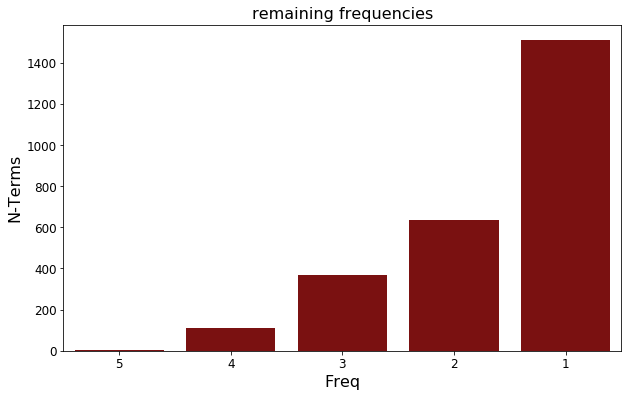

,0
5,2
4,111
3,369
2,635
1,1509


In [8]:
# get terms left to learn
to_learn = collections.Counter()
for i in heb.set_data['term_queues']['0']:
    term_lexs = heb.set_data['terms_dict'][i]['source_lexemes']
    for term in term_lexs:
        freq = heb.F.freq_lex.v(term)
        to_learn[freq] += 1           
to_learn = pd.DataFrame.from_dict(to_learn, orient='index').sort_values(by=0)

# make the plot
nbars = np.arange(to_learn.shape[0])
plt.figure(figsize=(10, 6))
sns.barplot(nbars, to_learn[0], color='darkred')
plt.xticks(nbars, labels=list(str(i) for i in to_learn.index), size=12)
plt.yticks(size=12)
plt.ylabel('N-Terms', size=16)
plt.xlabel('Freq', size=16)
plt.title(f'remaining frequencies', size=16)
plt.show()
display(to_learn)

In [14]:
results = []

for t,tdat in heb.set_data['terms_dict'].items():
    if (tdat['score'] == '0'
        and 3 in set(heb.F.freq_lex.v(l) for l in tdat['source_lexemes'])
        and 'verb' in set(heb.F.sp.v(l) for l in tdat['source_lexemes'])
       ):
        
        results.append((t, tdat))

len(results)

90

## Goals


### Learn them all
I want to knock out the remaining unlearned terms within the next year.

In [15]:
# year = 365 # days
# cycle_size = 10
# total_unlearned = to_learn.sum()[0]

# # based on previous cycle, calculate the quota 2 learned ratio
# zero_quota = 50
# learnedincycle = date2nlearned['04-07'] - date2nlearned['26-06'] # how many I've done in a cycle with 50
# quota2learned = zero_quota / learnedincycle
# learned2quota = learnedincycle / zero_quota
# print(f'The quota-to-learned ratio is: {quota2learned}')
# print(f'The learned-to-quota ratio is: {learned2quota}')

So 92% of terms in the zero quota were learned in this cycle period.

Let's see what's needed to knock out the remaining unlearned terms in a year.

In [14]:
(total_unlearned * quota2learned / year) * cycle_size

98.12388326384752

Thus, I need 98 terms per cycle.

### Future

Determine the best cycle length in the future when all terms are scores 3-4

In [26]:
known_scores = plt_scores[-1]
total = known_scores + total_unlearned

total / 15 # cycle length of 15

357.53333333333336

In [27]:
total / 20 # cycle length 

268.15

In [29]:
total / 30 # cycle length

178.76666666666668